# Importar bibibliotecas

In [17]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as drv
import numpy as np
import matplotlib.pyplot as plt

# Definición del Kernel

In [18]:
source_code_eca = r"""
extern "C"
__global__ void ECA_step(const int *c_old,
                         int *c_new,
                         const int *R_list, // largo 8: R_list[i] = i-ésimo dígito binario
                         int n)
{
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    if (i >= n) return;

    // Condición de contorno periódica
    int c_m1 = c_old[(i + n - 1) % n];  // c_{-1}
    int c_0  = c_old[i];                // c_{0}
    int c_p1 = c_old[(i + 1) % n];      // c_{1}

    // idx = 4*c_{-1} + 2*c_{0} + 1*c_{1}
    int idx = 4*c_m1 + 2*c_0 + c_p1;

    // c^{t+1}_i = R_list[idx]
    c_new[i] = R_list[idx];
}
"""

In [19]:
mod = SourceModule(source_code_eca)    
# Accede a las funciones del kernel
ECA_step = mod.get_function("ECA_step")

# Función que transforma $R$ en $R_{list}$

In [20]:
def rule_to_list(rule: int) -> np.ndarray:
    """Devuelve R_list (int32, largo 8), donde R_list[i] = bit i de rule."""
    return np.array([(rule >> i) & 1 for i in range(8)], dtype=np.int32)

# Configurar las condiciones iniciales

In [58]:
T = np.int32(150)
n = np.int32(150)  
R = 110
R_list = rule_to_list(R)
c_0 = cond_ini = np.zeros(n,dtype=np.int32)
c_0[n//2] = 1 

# Configurar parámetros GPU

In [59]:
block_size = (1024, 1, 1)
grid_size = (int(np.ceil(2*n / block_size[0])), 1, 1)

# # Inicialización vectores máximo

#Asignar memoria en el device
old_gpu = drv.mem_alloc(c_0.nbytes)
new_gpu = drv.mem_alloc(c_0.nbytes)
R_list_gpu = drv.mem_alloc(R_list.nbytes)


#Copiar los datos del host al device
drv.memcpy_htod(old_gpu, c_0)
drv.memcpy_htod(new_gpu, np.zeros(n,dtype=np.int32))
drv.memcpy_htod(R_list_gpu, R_list)


# Cálculo de la solución usando el Kernel de CUDA 

In [60]:
try:
    t=np.int32(0)
    T_actual    = 0
    soluciones  = []
    sim_guardar = T
    modulo=int(T/sim_guardar)
    times = []
    time=0


    for tt in range(1,T+1):
        #----------------- Actualización de data -----------------#
        ECA_step(old_gpu,new_gpu, R_list_gpu, n, block=block_size, grid=grid_size)
        old_gpu, new_gpu = new_gpu, old_gpu
        
        
        time+=1
        if time % modulo ==0:
            # Copiar los datos de vuelta al host y verificar
            data = np.empty_like(cond_ini)
            drv.memcpy_dtoh(data, old_gpu)
            soluciones.append(data)
            times.append(T_actual)
finally:
    
    # Liberar la memoria
    old_gpu.free()
    new_gpu.free()
    print("Memoria liberada")

Memoria liberada


# Ploteo 

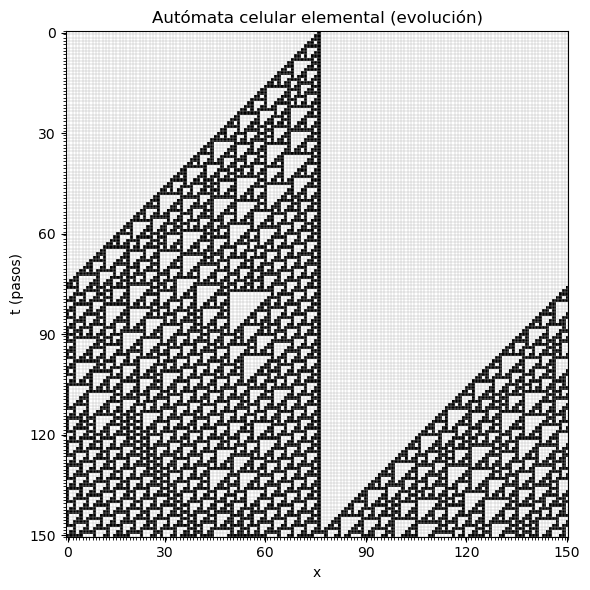

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Matriz (filas = tiempo, columnas = celda). Valores 0/1.
M = np.vstack([cond_ini[:n].astype(int)] + [s[:n].astype(int) for s in soluciones])
nt, nx = M.shape

fig, ax = plt.subplots(figsize=(12, 6))

# Dibujo tipo “cuadrícula” (cada pixel = una celda). aspect='equal' => celdas cuadradas.
im = ax.imshow(
    M,
    cmap="binary",
    interpolation="nearest",
    aspect="equal",
    origin="upper"
)

# Límites alineados a bordes de celdas
ax.set_xlim(-0.5, nx - 0.5)
ax.set_ylim(nt - 0.5, -0.5)

# --- Grilla ---
# OJO: si nx/nt son muy grandes, dibujar TODAS las líneas puede ser pesado.
step_x = max(1, nx // 200)   # ajusta “densidad” de líneas verticales
step_y = max(1, nt // 200)   # ajusta “densidad” de líneas horizontales

ax.set_xticks(np.arange(-0.5, nx, step_x), minor=True)
ax.set_yticks(np.arange(-0.5, nt, step_y), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.3)

# (Opcional) Ticks “bonitos” (no cada celda)
ax.set_xticks(np.linspace(0, nx-1, 6, dtype=int))
ax.set_xticklabels(np.round(np.linspace(0, n, 6, dtype=int), 2))  # etiqueta en coordenada x
ax.set_yticks(np.linspace(0, nt-1, 6, dtype=int))
ax.set_yticklabels(np.linspace(0, nt-1, 6, dtype=int))

ax.set_title("Autómata celular elemental (evolución)")
ax.set_xlabel("x")
ax.set_ylabel("t (pasos)")
plt.tight_layout()
plt.show()


# Arreglos 2 dimensionales en PyCUDA

In [63]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

# -----------------------------
# 1) Kernel CUDA (incrementa A[i,j] en +1)
# -----------------------------
kernel_code = r"""
extern "C"
__global__ void kernel(double *flat_A, int n)
{
    int i = blockIdx.y * blockDim.y + threadIdx.y; // fila
    int j = blockIdx.x * blockDim.x + threadIdx.x; // col

    if (i < n && j < n) {
        #define A(ii,jj) flat_A[(ii)*n + (jj)]
        A(i,j) = A(i,j) + 1.0;
        #undef A
    }
}
"""
mod = SourceModule(kernel_code)
k = mod.get_function("kernel")

# -----------------------------
# 2) Construir A (matriz) y aplanarla
# -----------------------------
n = 5
A = np.arange(n*n, dtype=np.float64).reshape(n, n)  # matriz en host
A = np.ascontiguousarray(A)                          # asegurar order C (contigua)
A_flat = A.ravel()                                   # vector 1D tamaño n*n

print("A (host) antes:\n", A)

# -----------------------------
# 3) Pasar a memoria global (device)
# -----------------------------
flat_gpu = drv.mem_alloc(A_flat.nbytes)
drv.memcpy_htod(flat_gpu, A_flat)

# -----------------------------
# 4) Ejecutar kernel (grilla 2D)
# -----------------------------
block = (16, 16, 1)
grid  = (int(np.ceil(n / block[0])), int(np.ceil(n / block[1])), 1)

k(flat_gpu, np.int32(n), block=block, grid=grid)

# -----------------------------
# 5) Recuperar datos desde memoria global
# -----------------------------
A_flat_out = np.empty_like(A_flat)
drv.memcpy_dtoh(A_flat_out, flat_gpu)

A_out = A_flat_out.reshape(n, n)  # reconstruir matriz nxn
print("\nA (host) después:\n", A_out)

A (host) antes:
 [[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]

A (host) después:
 [[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25.]]


# EL juego de la vida

Memoria liberada


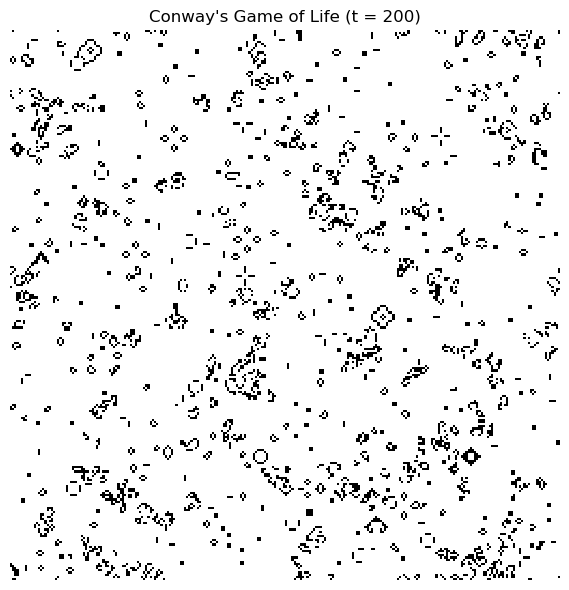

In [ ]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

life_code = r"""
extern "C"
__global__ void LifeStep(const int *old_g, int *new_g, int n)
{
    int i = blockIdx.y * blockDim.y + threadIdx.y; // fila
    int j = blockIdx.x * blockDim.x + threadIdx.x; // col
    if (i >= n || j >= n) return;

    int im1 = (i + n - 1) % n;
    int ip1 = (i + 1) % n;
    int jm1 = (j + n - 1) % n;
    int jp1 = (j + 1) % n;

    #define G(ii,jj) old_g[(ii)*n + (jj)]

    int alive = G(i,j);
    int neigh =
        G(im1,jm1) + G(im1,j) + G(im1,jp1) +
        G(i,  jm1)           + G(i,  jp1) +
        G(ip1,jm1) + G(ip1,j) + G(ip1,jp1);

    int out = 0;
    if (alive) {
        if (neigh == 2 || neigh == 3) {
            out = 1;   // sobrevive
        } else {
            out = 0;   // muere
        }
    } else {
        if (neigh == 3) {
            out = 1;   // nace
        } else {
            out = 0;   // sigue muerta
        }
    }

    new_g[i*n + j] = out;

    #undef G
}
"""
mod = SourceModule(life_code, options=["-std=c++11"])
LifeStep = mod.get_function("LifeStep")

# -----------------------------
# Parámetros y condición inicial
# -----------------------------
n = 256
T = 200
p = 0.2

A0 = (np.random.rand(n, n) < p).astype(np.int32)
cond_ini = np.ascontiguousarray(A0).ravel()

old_gpu = drv.mem_alloc(cond_ini.nbytes)
new_gpu = drv.mem_alloc(cond_ini.nbytes)
drv.memcpy_htod(old_gpu, cond_ini)
drv.memcpy_htod(new_gpu, np.zeros_like(cond_ini))

block_size = (16, 16, 1)
grid_size  = (int(np.ceil(n / block_size[0])), int(np.ceil(n / block_size[1])), 1)

try:
    soluciones  = []
    times       = []
    sim_guardar = T
    modulo      = max(1, int(T / sim_guardar))
    time = 0

    for tt in range(1, T + 1):
        LifeStep(old_gpu, new_gpu, np.int32(n), block=block_size, grid=grid_size)
        old_gpu, new_gpu = new_gpu, old_gpu

        time += 1
        if time % modulo == 0:
            data = np.empty_like(cond_ini)
            drv.memcpy_dtoh(data, old_gpu)
            soluciones.append(data.reshape(n, n))
            times.append(tt)

finally:
    old_gpu.free()
    new_gpu.free()
    print("Memoria liberada")

# (Opcional) plot del estado final
import matplotlib.pyplot as plt
final_state = soluciones[-1]
plt.figure(figsize=(6,6))
plt.imshow(final_state, cmap="binary", interpolation="nearest", aspect="equal")
plt.title(f"Conway's Game of Life (t = {times[-1]})")
plt.axis("off")
plt.tight_layout()
plt.show()
